In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import seaborn as sns

from PIL import Image
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score,accuracy_score

# IMPORTANT NOTICE

This notebook is the baseline. This is the notebook that was provided to us with the dataset.

You definitely do not need to run this. In fact, if you are the grader, there's a good chance that you helped with this notebook.

In [2]:
# Helper functions
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load all images
print("Loading " + str(n) + " images")

imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

n = 90 # Only use 90 images for training

Loading 100 images
Loading 100 images


Image size = 400,400


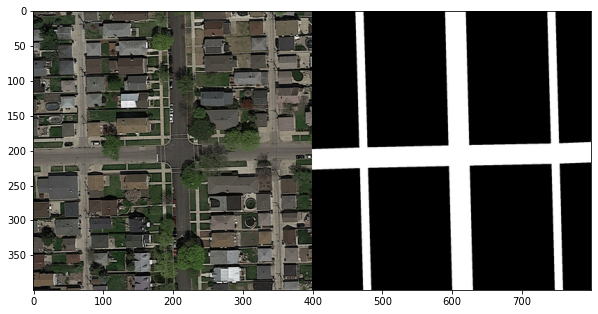

In [4]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [5]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

img_patches_test = [img_crop(imgs[i], patch_size, patch_size) for i in range(n,100)]
gt_patches_test = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n,100)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# Linearize list of patches test
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])
gt_patches_test =  np.asarray([gt_patches_test[i][j] for i in range(len(gt_patches_test)) for j in range(len(gt_patches_test[i]))])

In [6]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X

In [7]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

X_test = np.asarray([ extract_features_2d(img_patches_test[i]) for i in range(len(img_patches_test))])
Y_test = np.asarray([value_to_class(np.mean(gt_patches_test[i])) for i in range(len(gt_patches_test))])

In [8]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 56250 features
Feature dimension = 2
Number of classes = 1
Class 0: 41800 samples
Class 1: 14450 samples


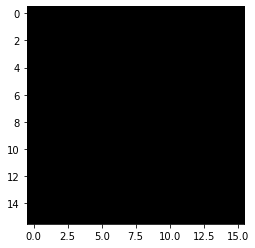

In [9]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

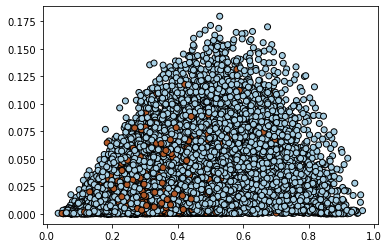

In [10]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [11]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced')

In [12]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

True positive rate = 0.1776888888888889


In [13]:
# Predict on the training set
Z_test = logreg.predict(X_test)

# Get non-zeros in prediction and grountruth arrays
Zn_test = np.nonzero(Z_test)[0]
Yn_test = np.nonzero(Y_test)[0]

TPR_test = len(list(set(Yn_test) & set(Zn_test))) / float(len(Z_test))
print('True positive rate = ' + str(TPR_test))

True positive rate = 0.18976


In [29]:
# generate a nice QR Code
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg
for img_idx in [23,5,2,1]:
    Xi = extract_img_features(f'test_set_images/test_{img_idx}/test_{img_idx}.png')
    Zi = logreg.predict(Xi)
    predicted_im = label_to_img(608, 608, patch_size, patch_size, Zi)
    Image.fromarray(img_float_to_uint8(predicted_im)).save(f'{img_idx}_baseline.png')

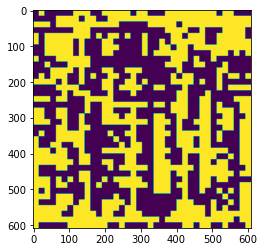

In [27]:
plt.imshow(predicted_im)

In [21]:
Zi

array([0, 0, 1, ..., 1, 1, 1])

In [16]:
precision_recall_fscore_support(Y_test, Z_test)

(array([0.77870813, 0.31694281]),
 array([0.43313373, 0.68121769]),
 array([0.55664814, 0.43260989]),
 array([4509, 1741], dtype=int64))

In [24]:
precision,f1,recall,accuracy = precision_score(Y_test, Z_test),f1_score(Y_test, Z_test),recall_score(Y_test, Z_test),accuracy_score(Y_test, Z_test)

In [25]:
print(f'precision: {precision}, f1_score: {f1}, recall:{recall}, accuracy:{accuracy} ')

precision: 0.3169428113308391, f1_score: 0.43260988509939813, recall:0.6812176909821941, accuracy:0.50224 


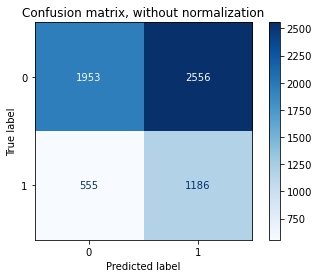

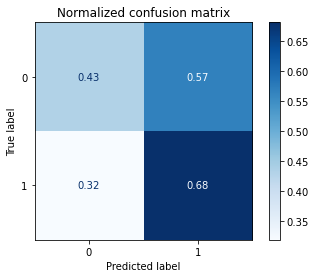

In [15]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(logreg, X_test, Y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

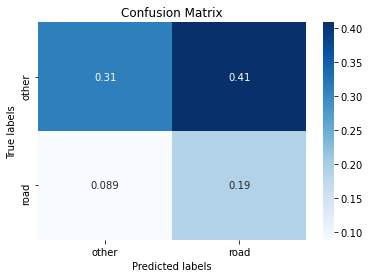

In [40]:
cm = confusion_matrix(Y_test, Z_test, normalize='all')
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap=plt.cm.Blues); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['other', 'road']); ax.yaxis.set_ticklabels(['other', 'road']);

In [41]:
print("Model accuracy: ", np.mean(Y_test == Z_test))

Model accuracy:  0.50224


In [42]:
from sklearn.metrics import f1_score
print("F1 score: ", f1_score(Y_test, Z_test, average='weighted'))

F1 score:  0.5220960438814457


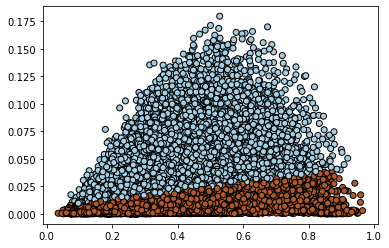

In [43]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [23]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

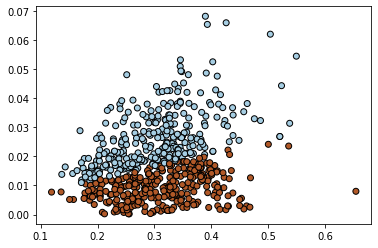

In [44]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

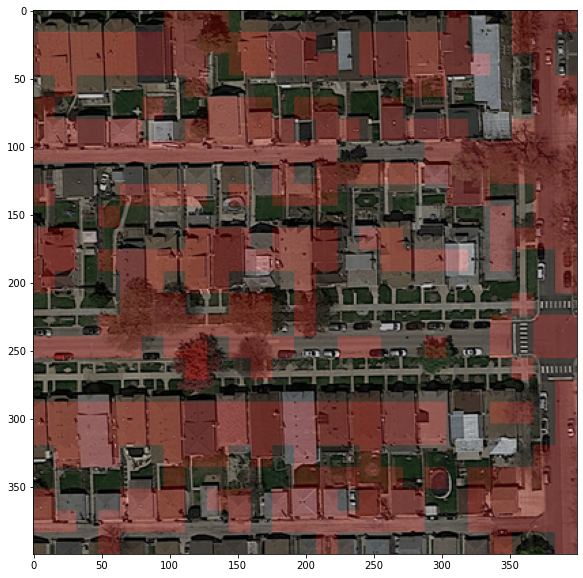

In [45]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)
